In [33]:
## 基础
import numpy as np
import pandas as pd
import warnings
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import jn
from IPython.display import display, clear_output
import time
warnings.filterwarnings('ignore')
%matplotlib inline
## 模型预测
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
## 数据降维
from sklearn.decomposition import PCA,FastICA,FactorAnalysis,SparsePCA
##使用两种，一种是lightgbm, 一种是xgb
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import GridSearchCV,cross_val_score,StratifiedKFold,train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

## 通过Pandas对于数据进行读取
Train_data = pd.read_csv("./used_car_train_20200313.csv", sep=' ')
TestA_data = pd.read_csv("./used_car_testB_20200421.csv", sep=' ')

## 输出数据的大小信息
print('训练shape:',Train_data.shape)
print('测试shape:',TestA_data.shape)

训练shape: (150000, 31)
测试shape: (50000, 30)


In [34]:
Train_data.head()
Train_data.info()
Train_data.columns
Train_data.describe()
TestA_data.info()
TestA_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 31 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   SaleID             150000 non-null  int64  
 1   name               150000 non-null  int64  
 2   regDate            150000 non-null  int64  
 3   model              149999 non-null  float64
 4   brand              150000 non-null  int64  
 5   bodyType           145494 non-null  float64
 6   fuelType           141320 non-null  float64
 7   gearbox            144019 non-null  float64
 8   power              150000 non-null  int64  
 9   kilometer          150000 non-null  float64
 10  notRepairedDamage  150000 non-null  object 
 11  regionCode         150000 non-null  int64  
 12  seller             150000 non-null  int64  
 13  offerType          150000 non-null  int64  
 14  creatDate          150000 non-null  int64  
 15  price              150000 non-null  int64  
 16  v_

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
count,50000.000000,50000.000000,5.000000e+04,50000.00000,50000.000000,48496.000000,47076.000000,48032.000000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,224999.500000,68505.606100,2.003401e+07,47.64948,8.087140,1.793736,0.376498,0.226953,119.766960,12.598260,...,0.248147,0.044624,0.124693,0.058198,0.062113,0.019633,0.002759,0.004342,0.004570,-0.007209
std,14433.901067,61032.124271,5.351615e+04,49.90741,7.899648,1.764970,0.549281,0.418866,206.313348,3.912519,...,0.045836,0.051664,0.201440,0.029171,0.035723,3.764095,3.289523,2.515912,1.287194,1.044718
min,200000.000000,1.000000,1.991000e+07,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-9.119719,-5.662163,-8.291868,-4.157649,-6.098192
25%,212499.750000,11315.000000,1.999100e+07,11.00000,1.000000,0.000000,0.000000,0.000000,75.000000,12.500000,...,0.243436,0.000035,0.062519,0.035413,0.033880,-3.675196,-1.963928,-1.865406,-1.048722,-0.440706
50%,224999.500000,52215.000000,2.003091e+07,30.00000,6.000000,1.000000,0.000000,0.000000,110.000000,15.000000,...,0.257818,0.000801,0.095880,0.056804,0.058749,1.632134,-0.375537,-0.138943,-0.036352,0.136849
75%,237499.250000,118710.750000,2.007110e+07,66.00000,13.000000,3.000000,1.000000,0.000000,150.000000,15.000000,...,0.265263,0.101654,0.125470,0.079387,0.087624,2.846205,1.263451,1.775632,0.945239,0.685555
max,249999.000000,196808.000000,2.015121e+07,246.00000,39.000000,7.000000,6.000000,1.000000,19211.000000,15.000000,...,0.291176,0.153403,1.411559,0.157458,0.211304,12.177864,18.789496,13.384828,5.635374,2.649768


In [35]:
#对日期的数据进行细化
Train_data[['regDate','creatDate']]
Train_data['regDate_year'] = Train_data['regDate'].astype('str').apply(lambda x: int(x[0:4]))
Train_data['regDate_month'] =Train_data['regDate'].astype('str').apply(lambda x: int(x[4:6]))
Train_data['regDate_day'] =Train_data['regDate'].astype('str').apply(lambda x: int(x[6:]))

Train_data['creatDate_year'] = Train_data['creatDate'].astype('str').apply(lambda x: int(x[0:4]))
Train_data['creatDate_month'] =Train_data['creatDate'].astype('str').apply(lambda x: int(x[4:6]))
Train_data['creatDate_day'] =Train_data['creatDate'].astype('str').apply(lambda x: int(x[6:]))

TestA_data['regDate_year'] = TestA_data['regDate'].astype('str').apply(lambda x: int(x[0:4]))
TestA_data['regDate_month'] =TestA_data['regDate'].astype('str').apply(lambda x: int(x[4:6]))
TestA_data['regDate_day'] =TestA_data['regDate'].astype('str').apply(lambda x: int(x[6:]))
TestA_data['creatDate_year'] = TestA_data['creatDate'].astype('str').apply(lambda x: int(x[0:4]))
TestA_data['creatDate_month'] =TestA_data['creatDate'].astype('str').apply(lambda x: int(x[4:6]))
TestA_data['creatDate_day'] =TestA_data['creatDate'].astype('str').apply(lambda x: int(x[6:]))

In [36]:
numerical_cols = Train_data.select_dtypes(exclude = 'object').columns
print(numerical_cols)
categorical_cols = Train_data.select_dtypes(include = 'object').columns
print(categorical_cols)

Index(['SaleID', 'name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType',
       'gearbox', 'power', 'kilometer', 'regionCode', 'seller', 'offerType',
       'creatDate', 'price', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6',
       'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14',
       'regDate_year', 'regDate_month', 'regDate_day', 'creatDate_year',
       'creatDate_month', 'creatDate_day'],
      dtype='object')
Index(['notRepairedDamage'], dtype='object')


In [37]:

feature_cols = [col for col in numerical_cols if col not in ['SaleID','price','regDate','creatDate']]
feature_cols = [col for col in feature_cols if 'Type' not in col]

## 提前特征列
X_data = Train_data[feature_cols]
Y_data = Train_data['price']

X_test  = TestA_data[feature_cols]
X_data.columns

Index(['name', 'model', 'brand', 'gearbox', 'power', 'kilometer', 'regionCode',
       'seller', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8',
       'v_9', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14', 'regDate_year',
       'regDate_month', 'regDate_day', 'creatDate_year', 'creatDate_month',
       'creatDate_day'],
      dtype='object')

In [38]:
## 定义了一个统计函数
def Sta_inf(data):
    print('_min',np.min(data))
    print('_max:',np.max(data))
    print('_mean',np.mean(data))
    print('_ptp',np.ptp(data))
    print('_std',np.std(data))
    print('_var',np.var(data))

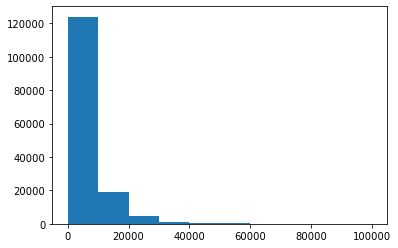

In [39]:
## 绘制标签的统计图
plt.hist(Y_data)
plt.show()
plt.close()

In [40]:
#填充
X_data = X_data.fillna(-1)
X_test = X_test.fillna(-1)

In [41]:
## xgb模型
xgr = xgb.XGBRegressor(n_estimators=120, learning_rate=0.1, gamma=0, subsample=0.8,\
        colsample_bytree=0.9, max_depth=7) #,objective ='reg:squarederror'

scores_train = []
scores = []

## 20折交叉验证
sk=StratifiedKFold(n_splits=20,shuffle=True,random_state=0)
for train_ind,val_ind in sk.split(X_data,Y_data):
    
    train_x=X_data.iloc[train_ind].values
    train_y=Y_data.iloc[train_ind]
    val_x=X_data.iloc[val_ind].values
    val_y=Y_data.iloc[val_ind]
    
    xgr.fit(train_x,train_y)
    pred_train_xgb=xgr.predict(train_x)
    pred_xgb=xgr.predict(val_x)
    
    score_train = mean_absolute_error(train_y,pred_train_xgb)
    scores_train.append(score_train)
    score = mean_absolute_error(val_y,pred_xgb)
    scores.append(score)

In [42]:
def build_model_xgb(x_train,y_train):
    model = xgb.XGBRegressor(n_estimators=150, learning_rate=0.1, gamma=0, subsample=0.8,\
        colsample_bytree=0.9, max_depth=7) #, objective ='reg:squarederror'
    model.fit(x_train, y_train)
    return model

def build_model_lgb(x_train,y_train):
    estimator = lgb.LGBMRegressor(num_leaves=127,n_estimators = 150)
    param_grid = {
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
    }
    gbm = GridSearchCV(estimator, param_grid)
    gbm.fit(x_train, y_train)
    return gbm

In [43]:
## 分数据
x_train,x_val,y_train,y_val = train_test_split(X_data,Y_data,test_size=0.3)

In [44]:
print('lgb开始训练...')
model_lgb = build_model_lgb(x_train,y_train)
val_lgb = model_lgb.predict(x_val)
MAE_lgb = mean_absolute_error(y_val,val_lgb)
print('MAE of val with lgb:',MAE_lgb)

print('lgb预测...')
model_lgb_pre = build_model_lgb(X_data,Y_data)
subA_lgb = model_lgb_pre.predict(X_test)
print('查看结果  lgb:')
Sta_inf(subA_lgb)

lgb开始训练...
MAE of val with lgb: 608.0720350949155
lgb预测...
查看结果  lgb:
_min -652.86353668197
_max: 92332.9221749113
_mean 5906.783185410658
_ptp 92985.78571159327
_std 7357.335425083576
_var 54130384.55718973


In [45]:
print('xgb开始训练...')
model_xgb = build_model_xgb(x_train,y_train)
val_xgb = model_xgb.predict(x_val)
MAE_xgb = mean_absolute_error(y_val,val_xgb)
print('MAE of val with xgb:',MAE_xgb)

print('xgb预测...')
model_xgb_pre = build_model_xgb(X_data,Y_data)
subA_xgb = model_xgb_pre.predict(X_test)
print('查看结果 xgb:')
Sta_inf(subA_xgb)

xgb开始训练...
MAE of val with xgb: 639.5129944275114
xgb预测...
查看结果 xgb:
_min -606.0304
_max: 90605.43
_mean 5907.0073
_ptp 91211.46
_std 7331.752
_var 53754584.0


In [46]:
## 加权融合
val_Weighted = (1-MAE_lgb/(MAE_xgb+MAE_lgb))*val_lgb+(1-MAE_xgb/(MAE_xgb+MAE_lgb))*val_xgb
val_Weighted[val_Weighted<0]=10 # 修正
print('MAE of val with Weighted ensemble:',mean_absolute_error(y_val,val_Weighted))

MAE of val with Weighted ensemble: 604.1915108490523


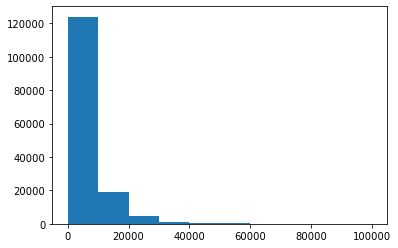

In [47]:
sub_Weighted = (1-MAE_lgb/(MAE_xgb+MAE_lgb))*subA_lgb+(1-MAE_xgb/(MAE_xgb+MAE_lgb))*subA_xgb

## 查看预测值
plt.hist(Y_data)
plt.show()
plt.close()

In [48]:
import pandas as pd
sub = pd.DataFrame()
sub['SaleID'] = TestA_data.SaleID
sub['price'] = sub_Weighted
sub.to_csv("./baseline_merge.csv",index=False)